In [1]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.random import gamma as tf_random_gamma
from tensorflow import data as tf_data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

#show the tensorflow version
print(tf.__version__)


2.10.1


In [2]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14130117037685544913
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5677768704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7185431091452592447
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


## Model (Drop-out + LS)

## Baseline Model with Dropout

In [4]:
#Build model
def create_model(dropout_rate):

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    


    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    # Block 4
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Block 5
    model.add(Dense(10, activation='softmax'))

    # Print the model summary
    #model.summary()
    # #Compile the model
    # model.compile(optimizer='adam',
    #     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #     metrics=['accuracy'])
    return model



In [6]:
dropout_rates = [0.5]
#all_histories = []
#y_train_encoded, y_test_encoded = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

for rate in dropout_rates:
    print(f"Training model with MaxDropout rate: {rate}")
    model = create_model(rate)

    #one hot labels
    y_train_1hot = tf.keras.utils.to_categorical(y_train, 10)
    y_test_1hot = tf.keras.utils.to_categorical(y_test, 10)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                 metrics=['accuracy', TopKCategoricalAccuracy(k=3)])  # Added Top-3 accuracy
    history = model.fit(x_train, y_train_1hot, epochs=60, validation_data=(x_test,y_test_1hot), callbacks=[tensorboard_callback])

    #all_histories.append(history)




Training model with MaxDropout rate: 0.5
Epoch 1/60
1563/1563 [==============================] - 17s 8ms/step - loss: 1.8480 - accuracy: 0.4202 - top_k_categorical_accuracy: 0.7489 - val_loss: 1.5982 - val_accuracy: 0.5813 - val_top_k_categorical_accuracy: 0.8740
Epoch 2/60
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5570 - accuracy: 0.6106 - top_k_categorical_accuracy: 0.8808 - val_loss: 1.4717 - val_accuracy: 0.6694 - val_top_k_categorical_accuracy: 0.9026
Epoch 3/60
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4469 - accuracy: 0.6772 - top_k_categorical_accuracy: 0.9098 - val_loss: 1.4048 - val_accuracy: 0.7066 - val_top_k_categorical_accuracy: 0.9210
Epoch 4/60
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3877 - accuracy: 0.7116 - top_k_categorical_accuracy: 0.9237 - val_loss: 1.3974 - val_accuracy: 0.7132 - val_top_k_categorical_accuracy: 0.9193
Epoch 5/60
1563/1563 [==============================] - 10s 6ms/ste

## Store loss & accuracy

In [7]:
#store training loss and validation loss as a numpy array
np.save('train_loss.npy', history.history['loss'])
np.save('val_loss.npy', history.history['val_loss'])
#store accuracy and validation accuracy as a numpy array
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
np.save('train_accuracy.npy', train_accuracy)
np.save('val_accuracy.npy', val_accuracy)
#store top 3 accuracy and validation top 3 accuracy as a numpy array
train_top3_accuracy = history.history['top_k_categorical_accuracy']
val_top3_accuracy = history.history['val_top_k_categorical_accuracy']
np.save('train_top3_accuracy.npy', train_top3_accuracy)
np.save('val_top3_accuracy.npy', val_top3_accuracy)



## load loss & accuracy

In [8]:
#load the loss and accuracy data
train_loss = np.load('train_loss.npy')
val_loss = np.load('val_loss.npy')
train_accuracy = np.load('train_accuracy.npy')
val_accuracy = np.load('val_accuracy.npy')
train_top3_accuracy = np.load('train_top3_accuracy.npy')
val_top3_accuracy = np.load('val_top3_accuracy.npy')


## Plot

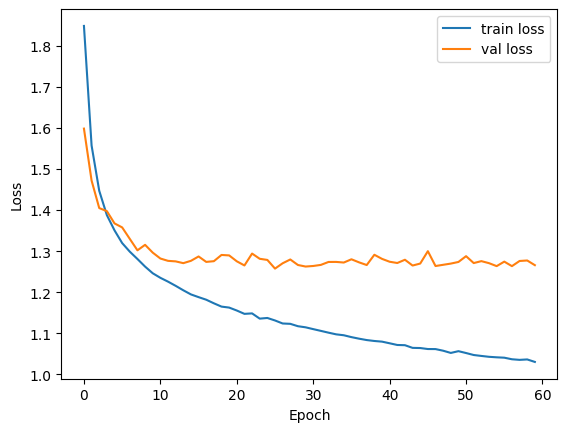

In [9]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper right')
#show plot
plt.show()


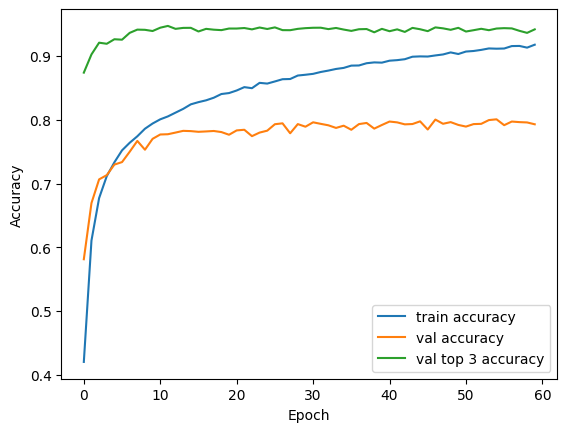

In [10]:
#plot accuracy
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label = 'val accuracy')
plt.plot(val_top3_accuracy, label = 'val top 3 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#legend
plt.legend(loc='lower right')
#show plot
plt.show()


In [11]:
#max accuracy
print(max(val_accuracy))
print(max(val_top3_accuracy))

0.8008000254631042
0.9473000168800354


In [12]:
## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.squeeze(y_test)
#change Y_true from One hot encoding to integers
Y_true = np.argmax(Y_true, axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
#plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()





313/313 [==============================] - 1s 3ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

## Save the trained Model

In [ ]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')